In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Data Exploration

In [36]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [37]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [38]:
print(f"Train Image Size: {train_images.shape}")
print(f"Train label Size: {train_labels.shape}")

print(f"Test Image Size: {test_images.shape}")
print(f"Test label Size: {test_labels.shape}")

Train Image Size: (60000, 28, 28)
Train label Size: (60000,)
Test Image Size: (10000, 28, 28)
Test label Size: (10000,)


In [39]:
print(f"Min value: {train_images[0].min()}\nMax Value: {train_images[0].max()}")

Min value: 0
Max Value: 255


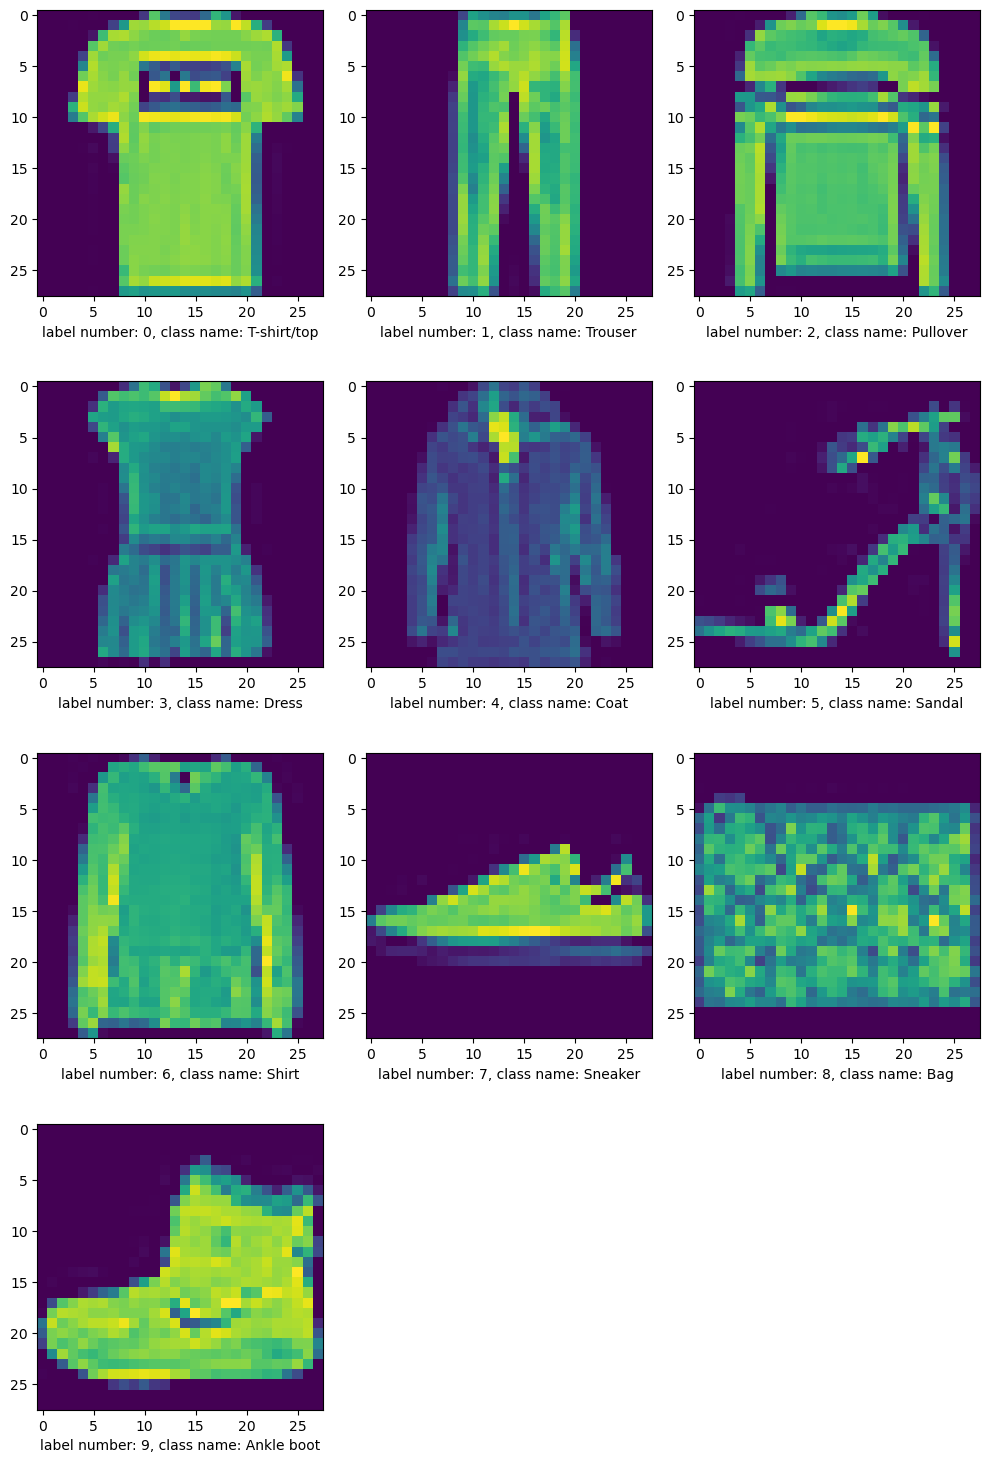

In [40]:
# Plotting images for each labels
unique_values, indices = np.unique(train_labels, return_index=True)

fig, axs= plt.subplots(4, 3, figsize=(10, 15))
axs= axs.flatten()
for (unique_value, index) in (zip(unique_values, indices)):
    axs[unique_value].imshow(train_images[index])
    axs[unique_value].set_xlabel(f"label number: {unique_value}, class name: {class_names[unique_value]}")

# Leave the last two plots empty
for i in range(10, 12):  # Optional: Remove axes
    axs[i].axis('off')


plt.tight_layout()
plt.show()

In [41]:
#Identify the count of images of each categories.
# np.c(train_labels)
import pandas as pd
unique_values, counts = np.unique(train_labels, return_counts=True)

train_image_label_df = pd.DataFrame( data = {'Categories Name': class_names, 'Label Id':unique_values, "Count": counts})
train_image_label_df

,Categories Name,Label Id,Count
0,T-shirt/top,0,6000
1,Trouser,1,6000
2,Pullover,2,6000
3,Dress,3,6000
4,Coat,4,6000
5,Sandal,5,6000
6,Shirt,6,6000
7,Sneaker,7,6000
8,Bag,8,6000
9,Ankle boot,9,6000


In [42]:
#Normalization in the range of [0 - 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

In [43]:
# One hot encoding, 
encoder = OneHotEncoder(sparse_output= False)
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

- If we want to use one hot encoded label data then we must use **Categorical Cross Entropy** as loss function. 
- If we use normal label data then we can use **Sparce Categorical Cross Entropy** as loss function.

# Model Building And Evaluation:

In [44]:
# Checking whether GPU or CPU used for model training
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
# This is done for the reproducability of the model
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Common Methods Used In Model Evaluations

In [46]:
# Method to plot train and validation accuracy and loss over epoches.
def PlotTrainAndValidationAccuracyAndLoss(nn_model_history: tf.keras.callbacks.History, model_name: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['accuracy'], label='Train', ax = axs[0])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_accuracy'], label='Validation', ax = axs[0])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')

    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['loss'], label='Train', ax = axs[1])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_loss'], label='Validation', ax = axs[1])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [47]:
#Model Evaluation function
def EvaluateNeuralNetworkModel(nn_model : tf.keras.Sequential, test_images: np.ndarray, test_labels: np.ndarray, test_labels_onehot: np.ndarray, model_name: str):
    model_test_loss, model_test_acc = nn_model.evaluate(test_images,  test_labels_onehot, verbose=2)

    print(f'\nTest accuracy for {model_name}: {model_test_acc:.4f}\n')
    print(f"Test loss for {model_name}: {model_test_loss:.4f}\n")
    
    model_prediction_result_softmax= nn_model.predict(test_images,batch_size= 32)

    model_test_label_pred = np.argmax(model_prediction_result_softmax, axis=1)  # Predicted labels

    print(f"first 10 predicted outputs: {model_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for neural network classification model
    model_classification_report = (classification_report(test_labels, model_test_label_pred))
    print(f"Classification report for {model_name} :\n{model_classification_report}")

    # Print a confusion matrix for neural network on test dataset

    model_confusion_matrix= (confusion_matrix(test_labels, model_test_label_pred))

    sns.heatmap(data= model_confusion_matrix,fmt='g', annot= True, cmap= "crest")
    plt.title(f"Confusion Matrix for the {model_name} on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    return model_prediction_result_softmax
    

In [48]:
# Model committee by averaging prediction of models: 
def ModelCommitteeAnalysis(model_result_softmax_list: list, test_labels: np.ndarray, model_name: str, is_object_return= False):
    model_committee_softmax = np.mean(model_result_softmax_list, axis= 0)
    model_committee_test_label_pred = np.argmax(model_committee_softmax, axis=1)  # Predicted labels

    loss = tf.keras.losses.CategoricalCrossentropy()(test_labels_onehot, model_committee_softmax).numpy()
    accuracy = accuracy_score(test_labels, model_committee_test_label_pred)

    print(f"Loss for the {model_name} on test dataset: {loss:.4f}")
    print(f"Accuracyensemble for the {model_name} on test dataset: {accuracy:.4f}")

    print(f"first 10 predicted outputs using committee by averaging predictions: {model_committee_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for committee of shallow neural network classification models
    model_committee_classification_report = (classification_report(test_labels, model_committee_test_label_pred))
    print(model_committee_classification_report)

    # Print a confusion matrix for committee of neural network on test dataset

    model_committee_confusion_matrix= (confusion_matrix(test_labels, model_committee_test_label_pred))

    sns.heatmap(data= model_committee_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
    plt.title(f"Confusion Matrix for the {model_name} neural network committee on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    if(is_object_return):
        return model_committee_softmax, model_committee_test_label_pred


## Shallow Neural Network

### shallow neural network 1

**Model Architecture**:
- 28 * 28 pixels images are provided as input to the model. 
- First step is to flatten the 2D inputs into 1D input parameters. 
- After Flatten, It is fed to the fist Dense layer. It contains 128 neurons and **relu** as activation function.
- It has output layers with 10 neurons. **Softmax** activation function is used in output layer.
- For the optimization of the model, We are using **ADAM** optimizer.
- For the loss calculation of the model, We are using **Categorical** Cross Entropy*.
- As an additional performance metrices, we are using **Accuracy** to evaluate the model during training. 

In [49]:
#Shallow Neural Network Model 1
shallow_nn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn1_history = shallow_nn_model1.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7712 - loss: 0.6580 - val_accuracy: 0.8505 - val_loss: 0.4272
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8615 - loss: 0.3957 - val_accuracy: 0.8592 - val_loss: 0.3890
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8770 - loss: 0.3477 - val_accuracy: 0.8687 - val_loss: 0.3614
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8844 - loss: 0.3194 - val_accuracy: 0.8769 - val_loss: 0.3421
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8916 - loss: 0.2983 - val_accuracy: 0.8788 - val_loss: 0.3374
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8971 - loss: 0.2815 - val_accuracy: 0.8831 - val_loss: 0.3306
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9014 - loss: 0.2675 - val_accuracy: 0.8853 - val_loss: 0.3249
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9056 - loss: 0

Model is trained over 100 epoches and 20% of the training dataset is separated as the validation set. For this model, We used batch size of 32. 

In [50]:
shallow_nn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_23 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

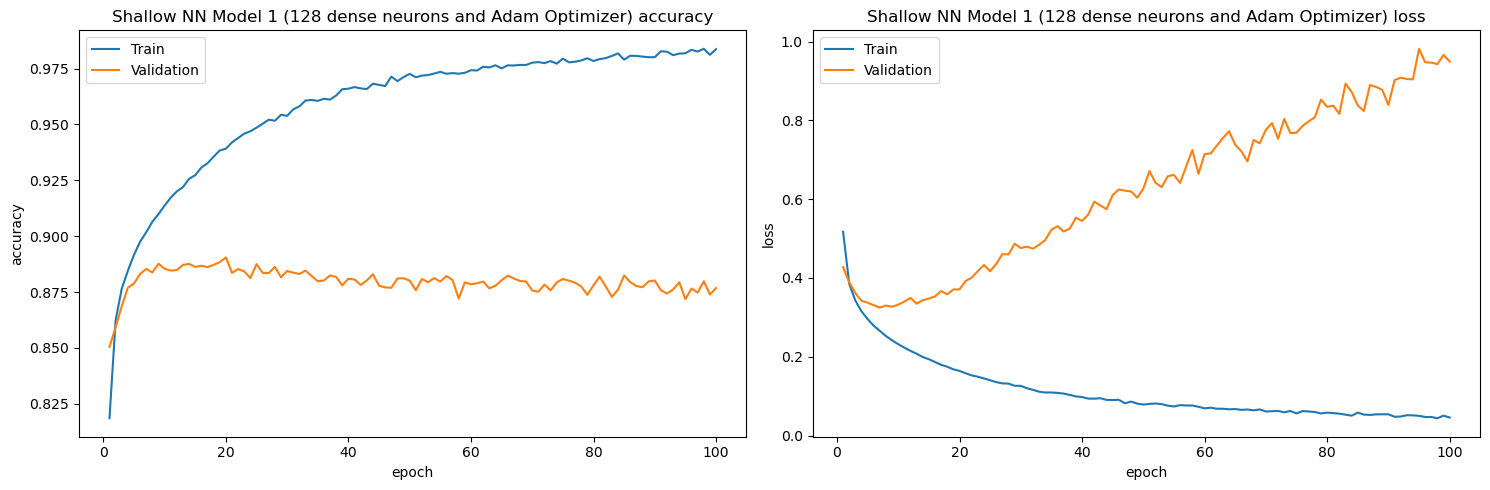

In [51]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn1_history, "Shallow NN Model 1 (128 dense neurons and Adam Optimizer)")


Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - If we look into the accracy of the train data set, it keeps improving over 100 epoches and it reached to the accuracy of 0.9852.
  - But in validation data set, accuracy increased initially but later it did not change over the epoches and maintain the validation accuracy of 0.8698. 
  - There is huge gap in training accuracy and validation accuracy. This is the case of over fitting. Model is able to predict the output accuratly on training dataset but not on validation dataset. 

- **Categorical Cross EntropyLoss**
  - Training loss started from the value of around 0.6569 and it kept decreasing and after around 40 epochs, loss started maintaing similar loss values. And finally at 100 epoches it showed the loss of 0.0425 for training data set. 
  - Similary For the validation dataset, loss values initially decreases but after few epochs it started increasing and after 100 epochs, it had the validation loss of 1.0076. Validation loss has huge deviation from training loss which showed that model is facing the problem of overfitting.

313/313 - 1s - 3ms/step - accuracy: 0.8702 - loss: 1.0842

Test accuracy for Shallow Neural Network 1: 0.8702

Test loss for Shallow Neural Network 1: 1.0842

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 1 :
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1000
           1       0.98      0.98      0.98      1000
           2       0.76      0.79      0.77      1000
           3       0.89      0.88      0.88      1000
           4       0.81      0.75      0.78      1000
           5       0.96      0.96      0.96      1000
           6       0.62      0.74      0.68      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.87     10000


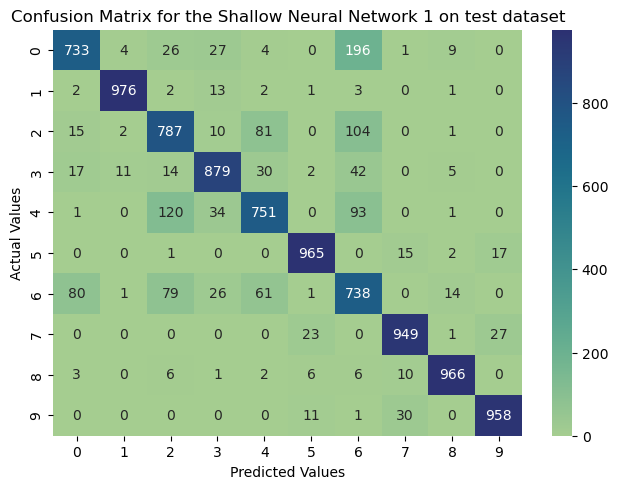

In [52]:
snn1_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model1, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 1")

Class 6 "Shirt" is misclassified for the most of the time. It is mostly confused with class 0 "T-shirt/top" and then with class 2 "Pullover" and then with class 5 "Coat".

### Shallow Neural Network Model 2

In this model, 
- We used 256 neurons in dense layer with **relu** activation function. 
- We used Adam Optimizer with initial learning rate of 0.001 as the optimization function. 
- While training model we use the batch size of 64. 

Other than that all architectural design is similar to the Shallow Neural Network 1. 

In [53]:
#Shallow Neural Network Model 2
shallow_nn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn2_history = shallow_nn_model2.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7697 - loss: 0.6577 - val_accuracy: 0.8558 - val_loss: 0.4127
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8587 - loss: 0.3983 - val_accuracy: 0.8712 - val_loss: 0.3720
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8734 - loss: 0.3481 - val_accuracy: 0.8773 - val_loss: 0.3507
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8820 - loss: 0.3193 - val_accuracy: 0.8821 - val_loss: 0.3390
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8920 - loss: 0.2968 - val_accuracy: 0.8815 - val_loss: 0.3373
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8973 - loss: 0.2802 - val_accuracy: 0.8831 - val_loss: 0.3330
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9026 - loss: 0.2645 - val_accuracy: 0.8832 - val_loss: 0.3350
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9091 - loss: 0.2495 - val_accu

In [54]:
shallow_nn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_24 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,592 (2.33 MB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,062 (1.55 MB)

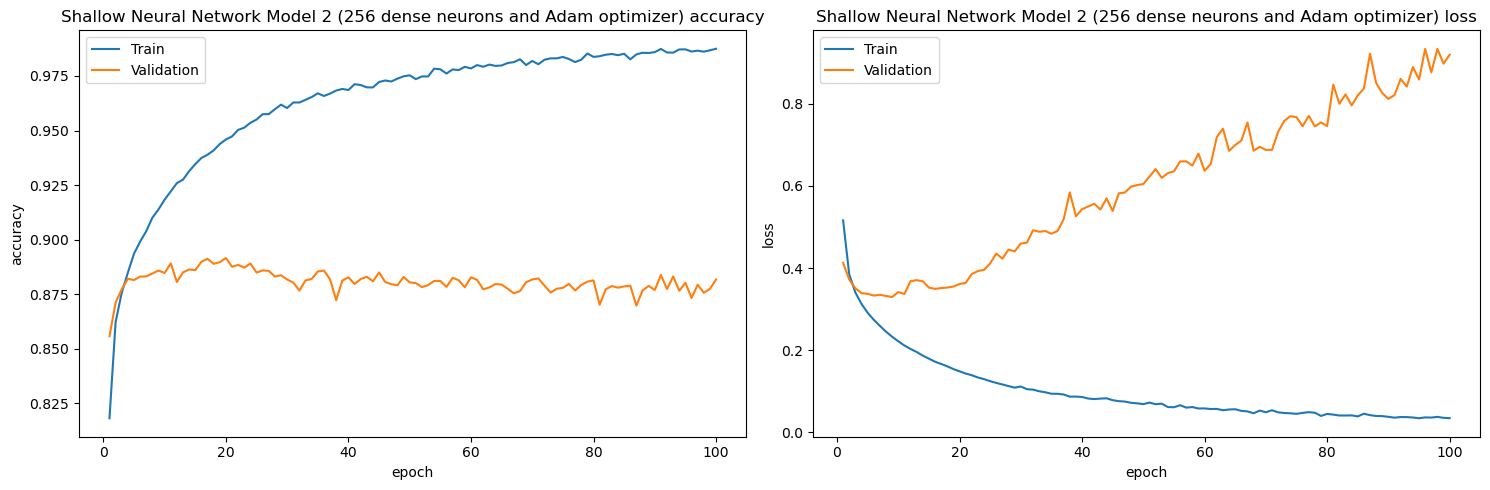

In [55]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn2_history, "Shallow Neural Network Model 2 (256 dense neurons and Adam optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9881.
  - Validation Accuracy of 0.8733. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.0324
  - Validation Loss: 0.9158

313/313 - 0s - 1ms/step - accuracy: 0.8787 - loss: 0.9388

Test accuracy for Shallow Neural Network 2: 0.8787

Test loss for Shallow Neural Network 2: 0.9388

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 2 :
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.85      0.91      0.88      1000
           4       0.86      0.71      0.78      1000
           5       0.97      0.96      0.97      1000
           6       0.65      0.77      0.70      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.88     10000


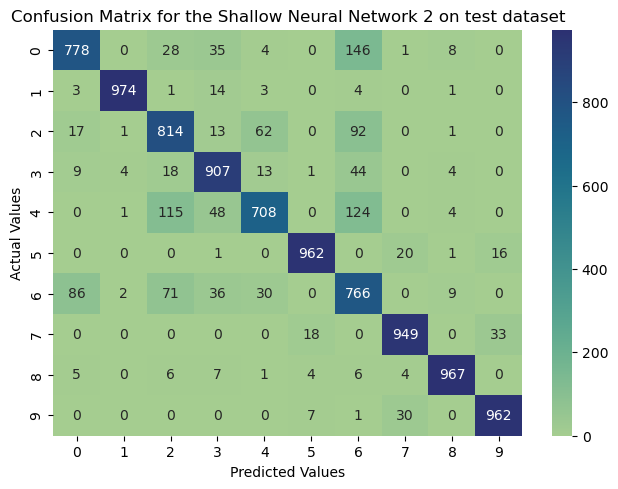

In [56]:
snn2_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model2, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 2")

### Shallow Neural Network Model 3

In this model, 
- I splitted the one dense layer of 256 neurons into the 2 dense layers with 128 neurons in each layer.
- Optimization function is also changed from Adam Optimizer to the SGD Optimizer. 

In [57]:
#Shallow Neural Network Model 3
shallow_nn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
shallow_nn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn3_history = shallow_nn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5113 - loss: 1.5687 - val_accuracy: 0.7491 - val_loss: 0.7451
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7637 - loss: 0.7074 - val_accuracy: 0.7997 - val_loss: 0.6090
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8037 - loss: 0.5934 - val_accuracy: 0.8176 - val_loss: 0.5516
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8199 - loss: 0.5392 - val_accuracy: 0.8266 - val_loss: 0.5185
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8290 - loss: 0.5066 - val_accuracy: 0.8311 - val_loss: 0.4961
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8370 - loss: 0.4842 - val_accuracy: 0.8353 - val_loss: 0.4800
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8416 - loss: 0.4676 - val_accuracy: 0.8382 - val_loss: 0.4675
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8449 - loss: 0.4545 - val_accu

In [58]:
shallow_nn_model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,148 (918.55 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

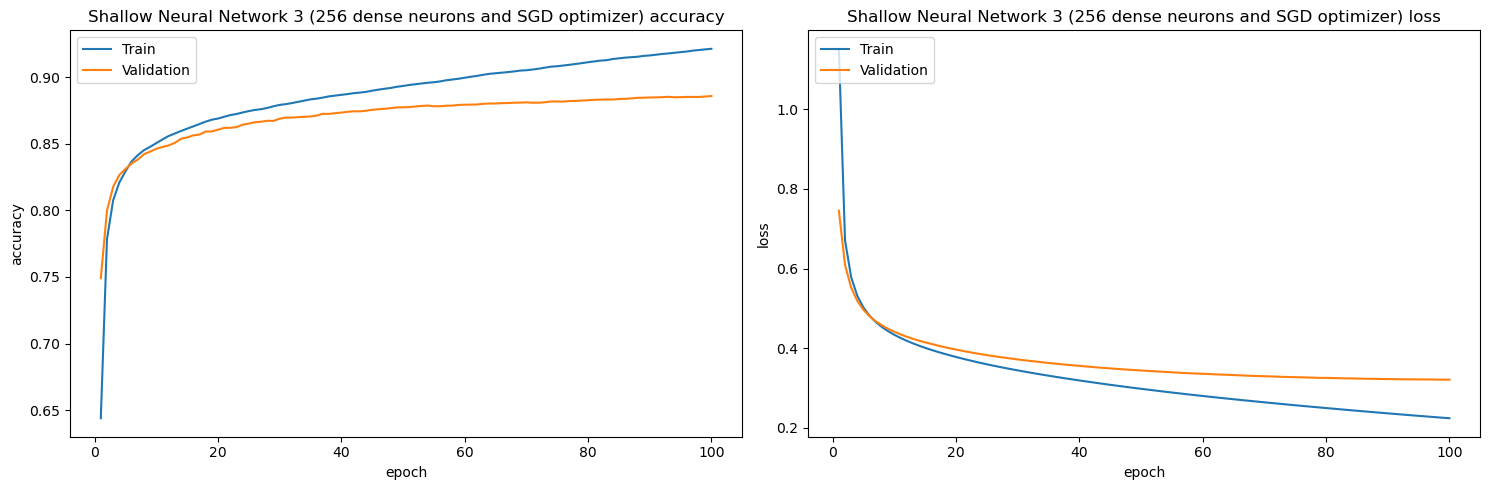

In [59]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn3_history, "Shallow Neural Network 3 (256 dense neurons and SGD optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9136.
  - Validation Accuracy of 0.8845. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.2454
  - Validation Loss: 0.3316

313/313 - 1s - 2ms/step - accuracy: 0.8769 - loss: 0.3436

Test accuracy for Shallow Neural Network 3: 0.8769

Test loss for Shallow Neural Network 3: 0.3436

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 3 :
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.85      0.89      0.87      1000
           4       0.82      0.79      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.67      0.73      0.70      1000
           7       0.92      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.88     10000


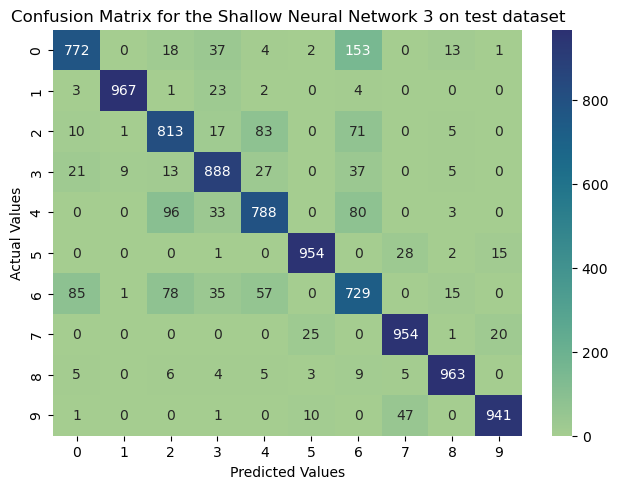

In [60]:
snn3_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model3, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 3")

## Simple Convolutional Neural Network

### Basic Convolutional Neural Network 1

**Model Architecture**
- Input layer accepts 28* 28 * 1 size of image. Here, image contains 28 pixels in width and 28 pixels in height and it has channel depth of 1. 
- Second layer is **Conv2d** layer. It contains 32 filters which means it generates 32 layers. Each filter has a kernel size of 3 * 3 that means it covers 3 pixel in width and 3 pixels in height at a time. **ReLU** is used as activation function for this layer. 
- Output from COnv2D layer ispassed into the max pooling layer. It has pool size of 2 * 2. This means it pick maximum output from each 2 * 2 grid in each layer. 
- After that, output from max pooling layer is flatten which is required to feed into the fully connected layer.
- Fully connected layer contains 128 neurons (nodes) with ReLU as activation function. 
- Output layer contains 10 neurons. Each neuron represents a category. 


In [61]:
simple_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn1_history = simple_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7974 - loss: 0.5641 - val_accuracy: 0.8852 - val_loss: 0.3291
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8943 - loss: 0.3003 - val_accuracy: 0.9001 - val_loss: 0.2846
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9122 - loss: 0.2455 - val_accuracy: 0.9033 - val_loss: 0.2746
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9260 - loss: 0.2076 - val_accuracy: 0.9079 - val_loss: 0.2681
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9380 - loss: 0.1746 - val_accuracy: 0.9070 - val_loss: 0.2862
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9490 - loss: 0.1452 - val_accuracy: 0.9059 - val_loss: 0.3042
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9578 - loss: 0.1190 - val_accuracy: 0.9112 - val_loss: 0.2984
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9667 - loss: 0

In [62]:
simple_cnn_model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,888 (7.94 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,387,926 (5.29 MB)

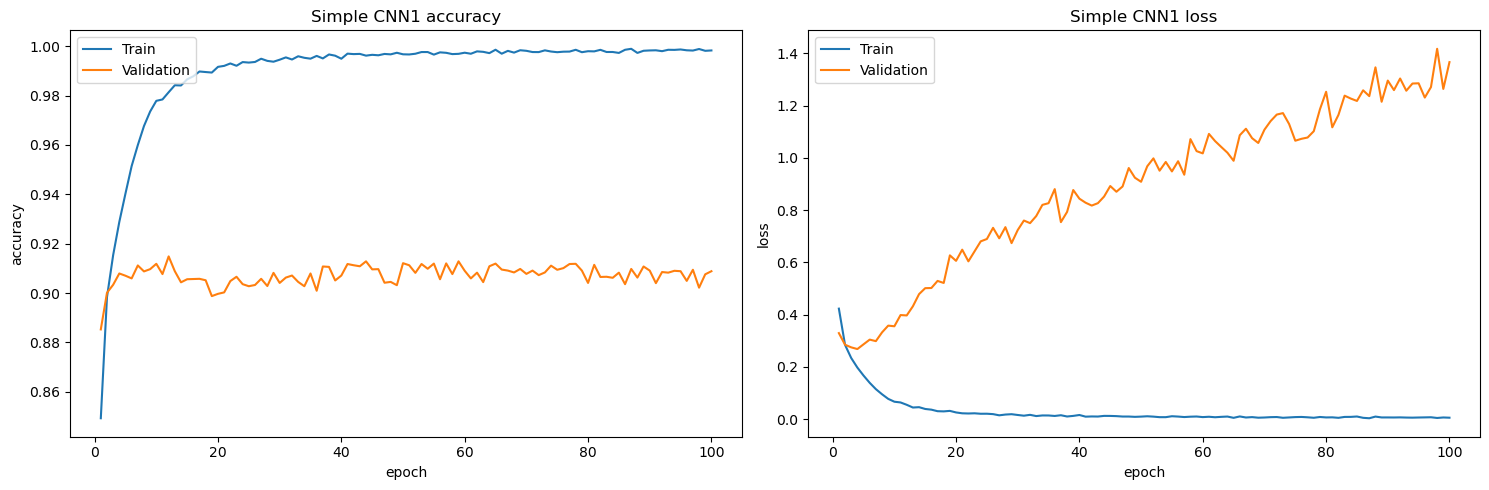

In [63]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn1_history, "Simple CNN1")

313/313 - 1s - 3ms/step - accuracy: 0.9030 - loss: 1.4607

Test accuracy for Simple CNN 1: 0.9030

Test loss for Simple CNN 1: 1.4607

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 2 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 1 :
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.84      0.84      1000
           3       0.89      0.92      0.90      1000
           4       0.81      0.88      0.84      1000
           5       0.99      0.96      0.98      1000
           6       0.78      0.69      0.73      1000
           7       0.95      0.98      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

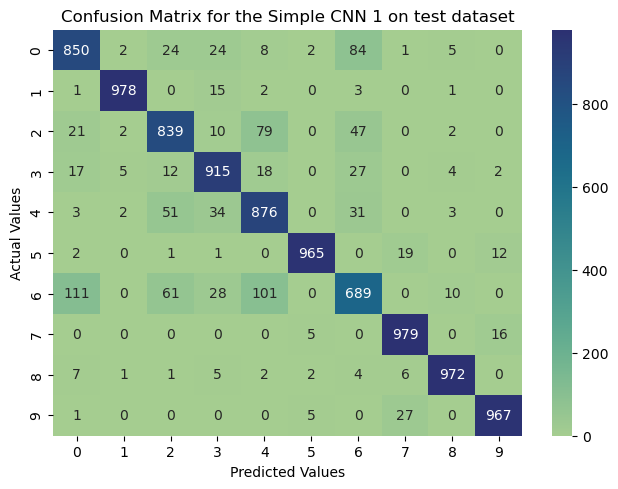

In [64]:
simple_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model1, test_images, test_labels, test_labels_onehot, "Simple CNN 1")

### Simple Convolutional Neural Netowrk 2

In [65]:
simple_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn2_history = simple_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8078 - loss: 0.5303 - val_accuracy: 0.8828 - val_loss: 0.3160
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8881 - loss: 0.2968 - val_accuracy: 0.8899 - val_loss: 0.2923
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9074 - loss: 0.2441 - val_accuracy: 0.8972 - val_loss: 0.2880
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9220 - loss: 0.2101 - val_accuracy: 0.8822 - val_loss: 0.3567
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9312 - loss: 0.1840 - val_accuracy: 0.8848 - val_loss: 0.4076
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9364 - loss: 0.1688 - val_accuracy: 0.8817 - val_loss: 0.4200
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9417 - loss: 0.1511 - val_accuracy: 0.8923 - val_loss: 0.4228
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9488 - loss: 0.1342 - val_accu

In [66]:
simple_cnn_model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,156,128 (12.04 MB)

 Trainable params: 1,052,042 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,104,086 (8.03 MB)

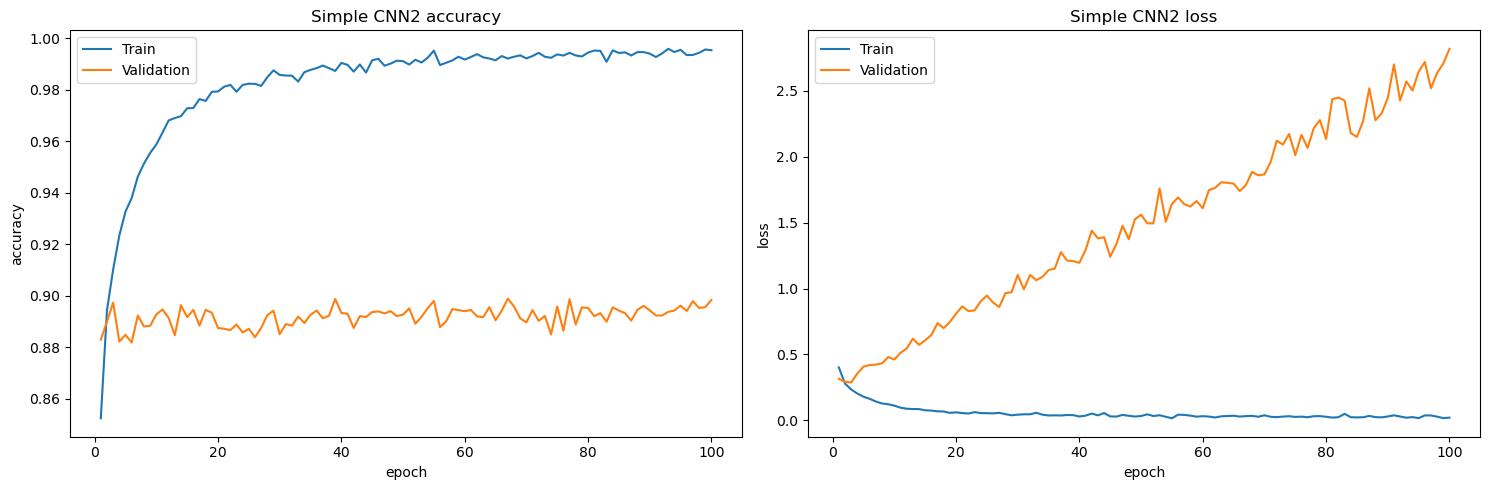

In [67]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn2_history, "Simple CNN2")

313/313 - 1s - 2ms/step - accuracy: 0.8947 - loss: 3.0913

Test accuracy for Simple CNN 2: 0.8947

Test loss for Simple CNN 2: 3.0913

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 2 :
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.90      0.90      1000
           4       0.81      0.84      0.82      1000
           5       0.99      0.98      0.98      1000
           6       0.73      0.67      0.70      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89   

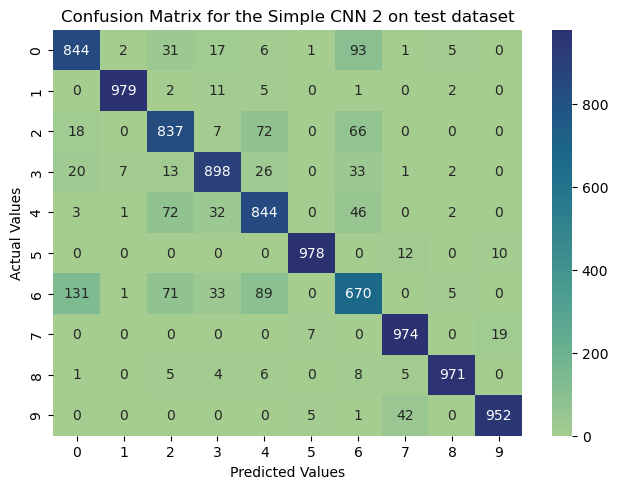

In [68]:
simple_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model2, test_images, test_labels, test_labels_onehot, "Simple CNN 2")

### Simple Convolutional Neural Network 3

In [69]:
simple_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn3_history = simple_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5824 - loss: 1.3803 - val_accuracy: 0.7790 - val_loss: 0.6277
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.6043 - val_accuracy: 0.8069 - val_loss: 0.5413
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8093 - loss: 0.5292 - val_accuracy: 0.8191 - val_loss: 0.5051
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8227 - loss: 0.4931 - val_accuracy: 0.8279 - val_loss: 0.4823
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8316 - loss: 0.4694 - val_accuracy: 0.8338 - val_loss: 0.4655
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8388 - loss: 0.4516 - val_accuracy: 0.8400 - val_loss: 0.4521
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8453 - loss: 0.4374 - val_accuracy: 0.8433 - val_loss: 0.4408
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8509 - loss: 0.4251 - val_accu

In [70]:
simple_cnn_model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │     1,384,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,596 (5.29 MB)

 Trainable params: 1,387,594 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

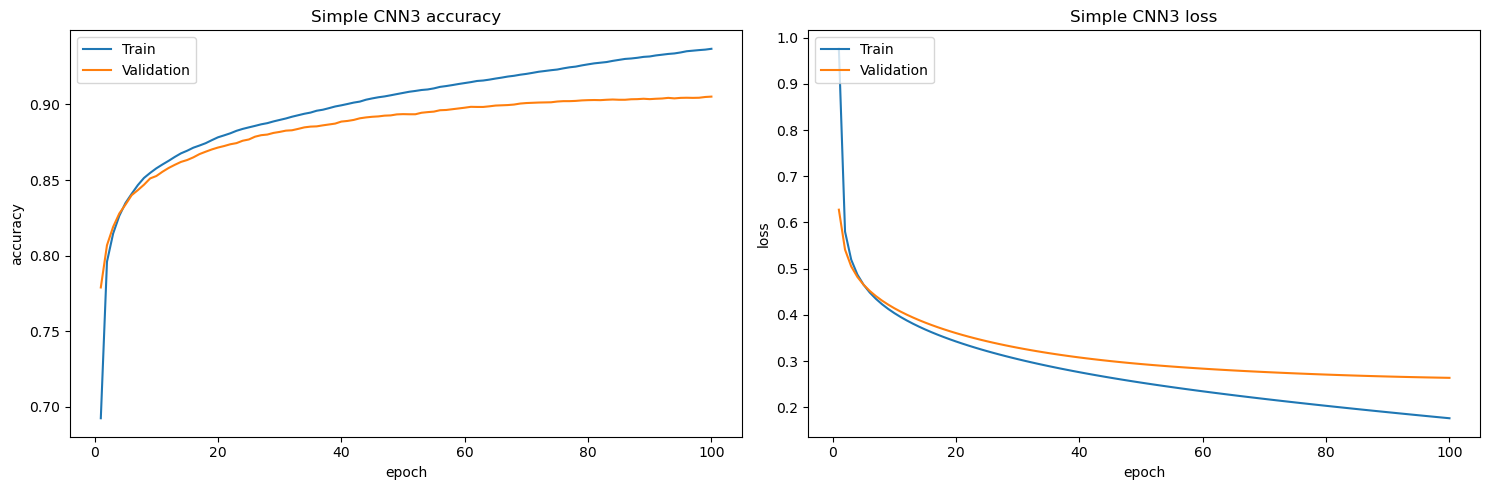

In [71]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn3_history, "Simple CNN3")

313/313 - 1s - 2ms/step - accuracy: 0.8993 - loss: 0.2762

Test accuracy for Simple CNN 3: 0.8993

Test loss for Simple CNN 3: 0.2762

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 3 :
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.81      0.86      0.83      1000
           3       0.89      0.91      0.90      1000
           4       0.85      0.81      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.76      0.74      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

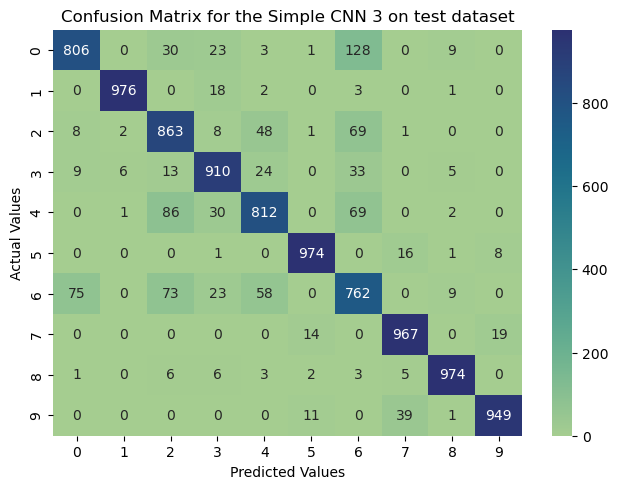

In [72]:
simple_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model3, test_images, test_labels, test_labels_onehot, "Simple CNN 3")

## Deep Convolution Neural Network

### Deep CNN Model 1

- Two Convolutional layers
- Two Max pooling layers
- One Fully Connected layers
- One Output layer

**Model Architecture**
- Input layer accepts images of shape 28\*28\*1.
- First hidden layer uses Conv2D layer. It has 32 filters with kernel size of 3\*3. This layer uses ReLU as activation function. 
- Output from 1st convolution layer is passed into first max pooling layer. This layer uses pooling sizes of 2 \* 2.
- Output from first max pooling layer is then passed into the second convolutional layer. Second convolutional layer contains 128 filters with kernel size of 3 \* 3 and it also uses ReLU as activation function. 
- Second max pooling layer is used after second convolutional layer. It has pool size of 3* 3. 
- After that output from second max pooling layer is flattened first and then is fed into the fully connected layer. Fully connected layer contains 256 neurons and uses tanh activation function. 
- Output layer contains 10 neurons with activation function of softmax.


In [73]:
deep_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn1_history = deep_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7737 - loss: 0.6158 - val_accuracy: 0.8811 - val_loss: 0.3311
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8852 - loss: 0.3233 - val_accuracy: 0.8933 - val_loss: 0.3016
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9021 - loss: 0.2697 - val_accuracy: 0.9033 - val_loss: 0.2766
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9152 - loss: 0.2323 - val_accuracy: 0.9052 - val_loss: 0.2720
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9260 - loss: 0.2006 - val_accuracy: 0.9075 - val_loss: 0.2774
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9362 - loss: 0.1745 - val_accuracy: 0.9053 - val_loss: 0.2912
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9458 - loss: 0.1492 - val_accuracy: 0.9035 - val_loss: 0.3023
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9539 - loss: 0.1286 - val_accu

In [74]:
deep_cnn_model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,578,016 (9.83 MB)

 Trainable params: 859,338 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,718,678 (6.56 MB)

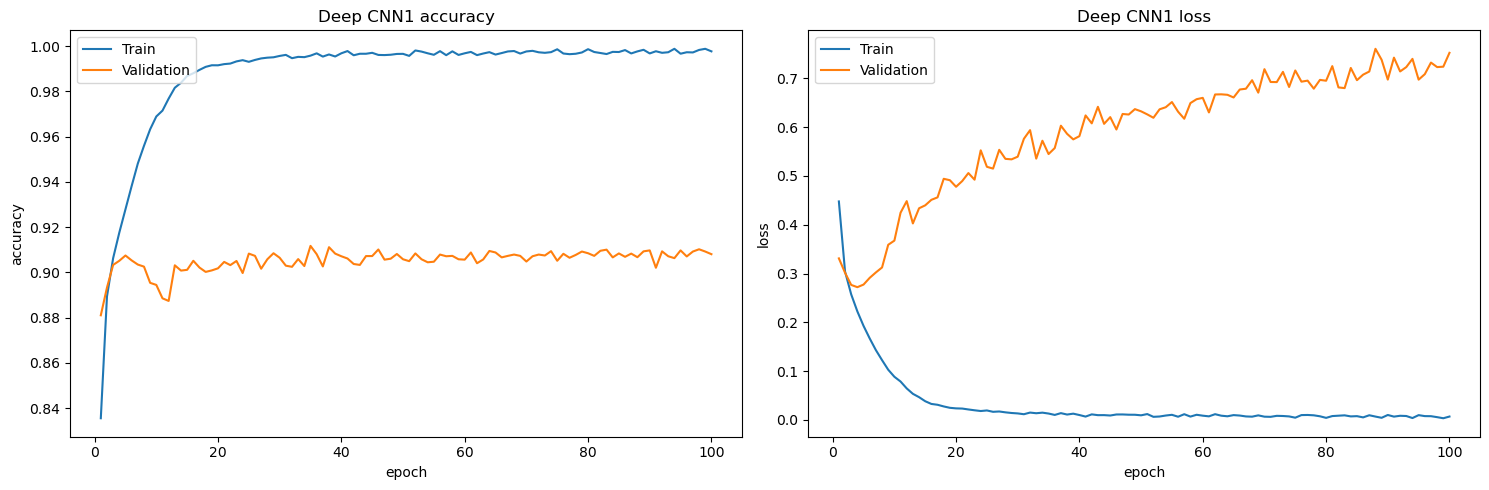

In [75]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn1_history, "Deep CNN1")

313/313 - 1s - 2ms/step - accuracy: 0.9056 - loss: 0.7671

Test accuracy for Deep CNN 1: 0.9056

Test loss for Deep CNN 1: 0.7671

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 1 :
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.84      0.86      1000
           3       0.93      0.90      0.91      1000
           4       0.80      0.90      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.76      0.71      0.73      1000
           7       0.93      0.98      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.9

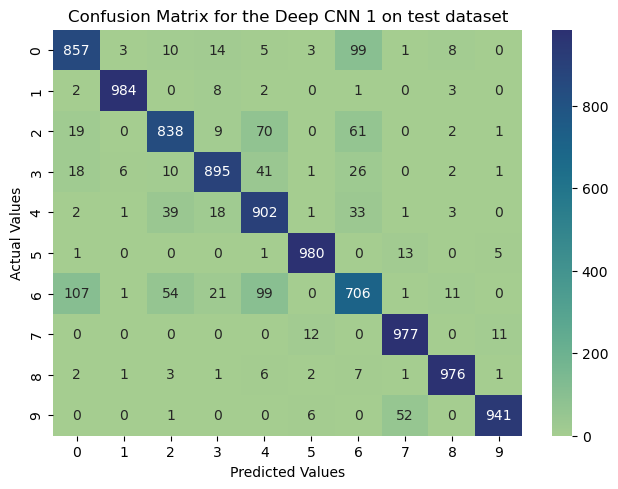

In [76]:
deep_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model1, test_images, test_labels, test_labels_onehot, "Deep CNN 1")

### Deep CNN Model 2

**Model Architecture**
This model contains 3 convolutional layers and 3 max pooling layers and one fully connected layer. 
- First convolutional layer contains 32 filters with kernel size of 3 * 3 and ReLU activation function.
- Second convolutional layer contains 64 filters with kernel size of 3 * 3 and ReLU activation function.
- Third convolutional layer contains 128 filters with kernel size of 3 * 3 and ReLU activation function.
- All 3 max pooling layer has pool size of 2 * 2. 
- Fully connected layer has 256 neurons (nodes) with tanh activation function. 
- Output layer contains 10 nodes and softmax as activation function. 
- Adam Optimizer is used as optimization function. 
- Categorical cross entropy is used as loss function. 
- Model is trained upto 100 epochs with 20% of training records as validation data and with batch size of 64.

In [77]:
deep_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn2_history = deep_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6817 - loss: 0.8544 - val_accuracy: 0.8378 - val_loss: 0.4431
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8419 - loss: 0.4317 - val_accuracy: 0.8612 - val_loss: 0.3758
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8663 - loss: 0.3662 - val_accuracy: 0.8729 - val_loss: 0.3452
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8801 - loss: 0.3233 - val_accuracy: 0.8780 - val_loss: 0.3268
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8900 - loss: 0.2926 - val_accuracy: 0.8813 - val_loss: 0.3221
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8991 - loss: 0.2671 - val_accuracy: 0.8827 - val_loss: 0.3224
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9089 - loss: 0.2453 - val_accuracy: 0.8817 - val_loss: 0.3373
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9158 - loss: 0.2267 - val_accu

In [78]:
deep_cnn_model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,800 (1.47 MB)

 Trainable params: 128,266 (501.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,534 (1002.09 KB)

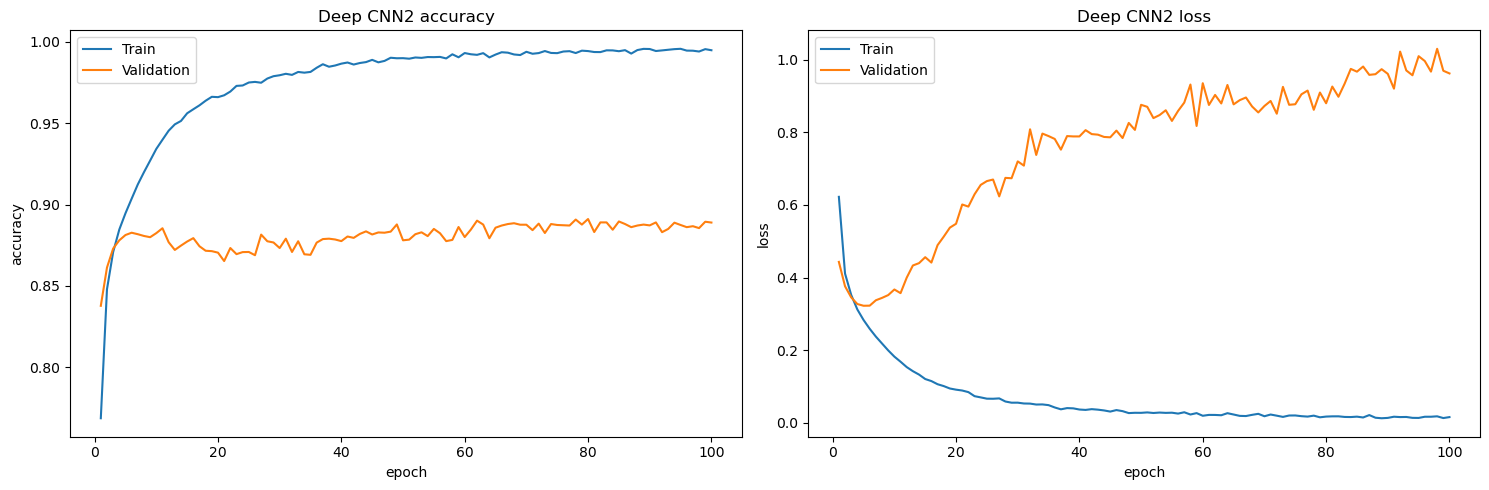

In [79]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn2_history, "Deep CNN2")

313/313 - 1s - 3ms/step - accuracy: 0.8877 - loss: 0.9947

Test accuracy for Deep CNN 2: 0.8877

Test loss for Deep CNN 2: 0.9947

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 2 :
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.91      0.88      0.89      1000
           4       0.77      0.89      0.83      1000
           5       0.97      0.96      0.97      1000
           6       0.72      0.63      0.67      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.8

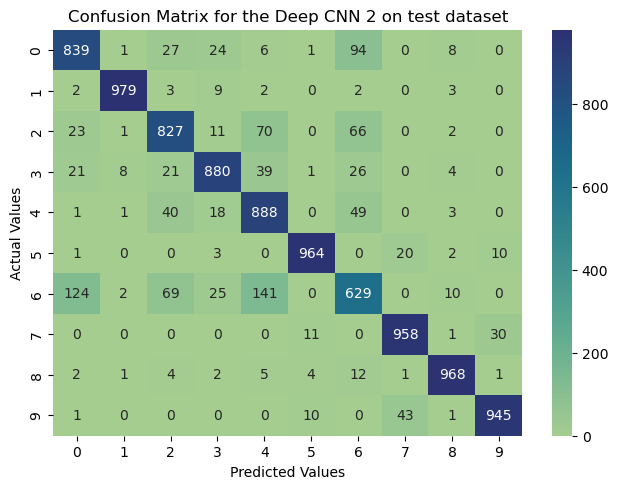

In [80]:
deep_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model2, test_images, test_labels, test_labels_onehot, "Deep CNN 2")

### Deep CNN Model 3

**Model Architecture**
- This model contains 2 convolutional layers, two max-pooling layers, one fully connected layer and one output layer. 
- First Convolutional has 32 filters and kernel size of 3 * 3 with ReLU as activation function. 
- Second Convolution layer has 64 filters with kernel size of 3 * 3 and ReLU as activation function. 
- Two max pooling layers have same pool size of 2 * 2. 
- Fully connected layer has 256 neurons and tanh as activation function. 
- Output layer has 10 neurons and softmax as activation function. 
- SGD is used as optimization function with initial learning rate of 0.005.
-  Model is trained for 100 epochs with batch size of 64.

In [81]:
deep_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn3_history = deep_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4236 - loss: 1.8429 - val_accuracy: 0.7284 - val_loss: 0.7938
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7226 - loss: 0.7672 - val_accuracy: 0.7666 - val_loss: 0.6606
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7581 - loss: 0.6584 - val_accuracy: 0.7812 - val_loss: 0.5999
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7775 - loss: 0.6012 - val_accuracy: 0.7937 - val_loss: 0.5592
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7902 - loss: 0.5609 - val_accuracy: 0.8039 - val_loss: 0.5295
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8011 - loss: 0.5304 - val_accuracy: 0.8126 - val_loss: 0.5062
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8106 - loss: 0.5058 - val_accuracy: 0.8180 - val_loss: 0.4876
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8198 - loss: 0.4856 - val_accu

In [82]:
deep_cnn_model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,244 (1.65 MB)

 Trainable params: 431,242 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

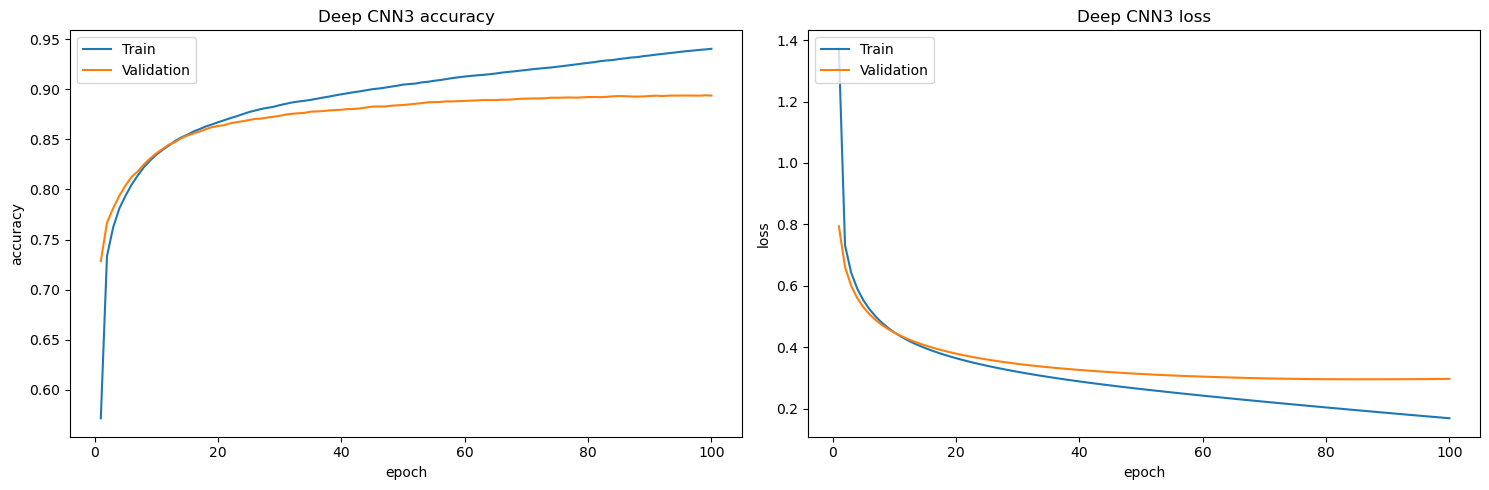

In [83]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn3_history, "Deep CNN3")

313/313 - 1s - 2ms/step - accuracy: 0.8906 - loss: 0.3098

Test accuracy for Deep CNN 3: 0.8906

Test loss for Deep CNN 3: 0.3098

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 3 :
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.85      0.84      1000
           3       0.90      0.90      0.90      1000
           4       0.81      0.84      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.67      0.70      0.69      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.8

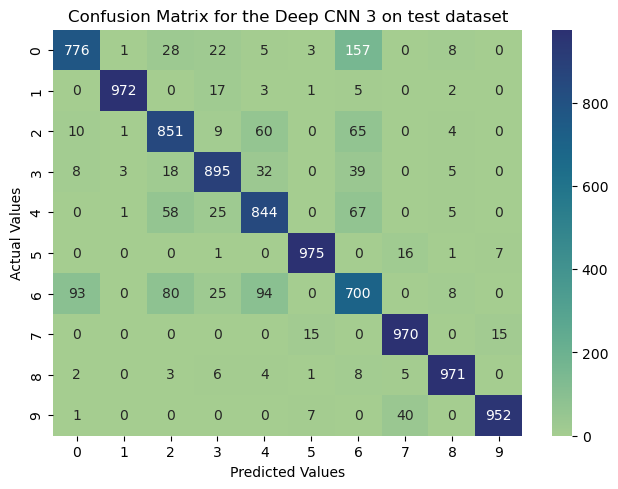

In [84]:
deep_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model3, test_images, test_labels, test_labels_onehot, "Deep CNN 3")

## Committee of Models (Shallow Neural Network, Simple Convolutional Neural Network and Deep Convolutional Neural Network)

Loss for the Committee of Model on test dataset: 0.2732
Accuracyensemble for the Committee of Model on test dataset: 0.9029
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1000
           1       1.00      0.97      0.98      1000
           2       0.83      0.87      0.85      1000
           3       0.90      0.91      0.90      1000
           4       0.85      0.84      0.84      1000
           5       0.98      0.97      0.98      1000
           6       0.72      0.77      0.74      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90 

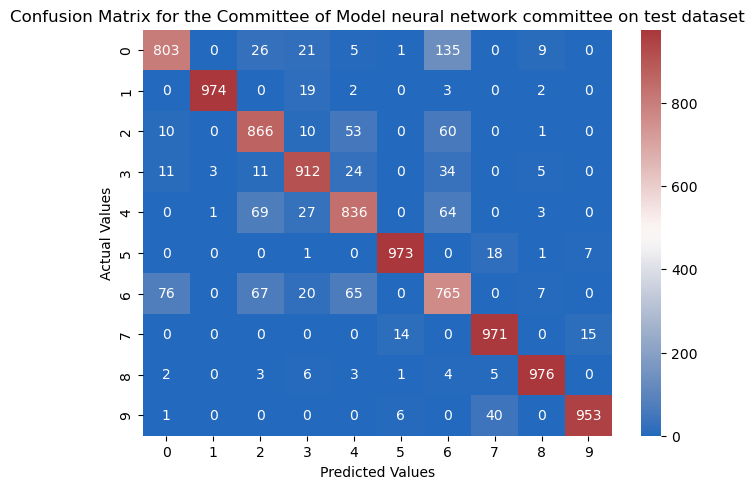

In [85]:
ModelCommitteeAnalysis(
    [snn3_prediction_result_softmax, 
     simple_cnn3_prediction_result_softmax, 
     deep_cnn3_prediction_result_softmax],
     test_labels,
     "Committee of Model"
)

## Extra Task: Data Augmentation, Dropout, and Batch Normalization

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_onehot, test_size= 0.2, random_state= 42)

train_images_with_channel = tf.expand_dims(X_train, axis= -1)

data_augumentation = tf.keras.Sequential([
    #Data Augumentation 
    tf.keras.layers.RandomFlip(mode= "horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2),
])

# # data_augumentation()
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_with_channel, y_train))

# Shuffle, augment, batch, and prefetch the training data
batch_size = 64
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)  # Shuffle the data
    .map(lambda x, y: (data_augumentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .batch(batch_size)  # Batch the data
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
)


In [87]:
nn_model_with_data_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

nn_model_with_data_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

nn_model_with_data_aug_history = nn_model_with_data_aug.fit(train_dataset , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6141 - loss: 1.1328 - val_accuracy: 0.5963 - val_loss: 1.2047
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7270 - loss: 0.7550 - val_accuracy: 0.6933 - val_loss: 0.9104
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7463 - loss: 0.7051 - val_accuracy: 0.6592 - val_loss: 0.9903
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7547 - loss: 0.6788 - val_accuracy: 0.7108 - val_loss: 0.8071
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7670 - loss: 0.6473 - val_accuracy: 0.7330 - val_loss: 0.7689
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7656 - loss: 0.6451 - val_accuracy: 0.6880 - val_loss: 1.0224
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7701 - loss: 0.6377 - val_accuracy: 0.5647 - val_loss: 2.1087
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7721 - loss: 0.6340 - val_ac

In [88]:
nn_model_with_data_aug.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,496 (4.94 MB)

 Trainable params: 431,434 (1.65 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 862,870 (3.29 MB)

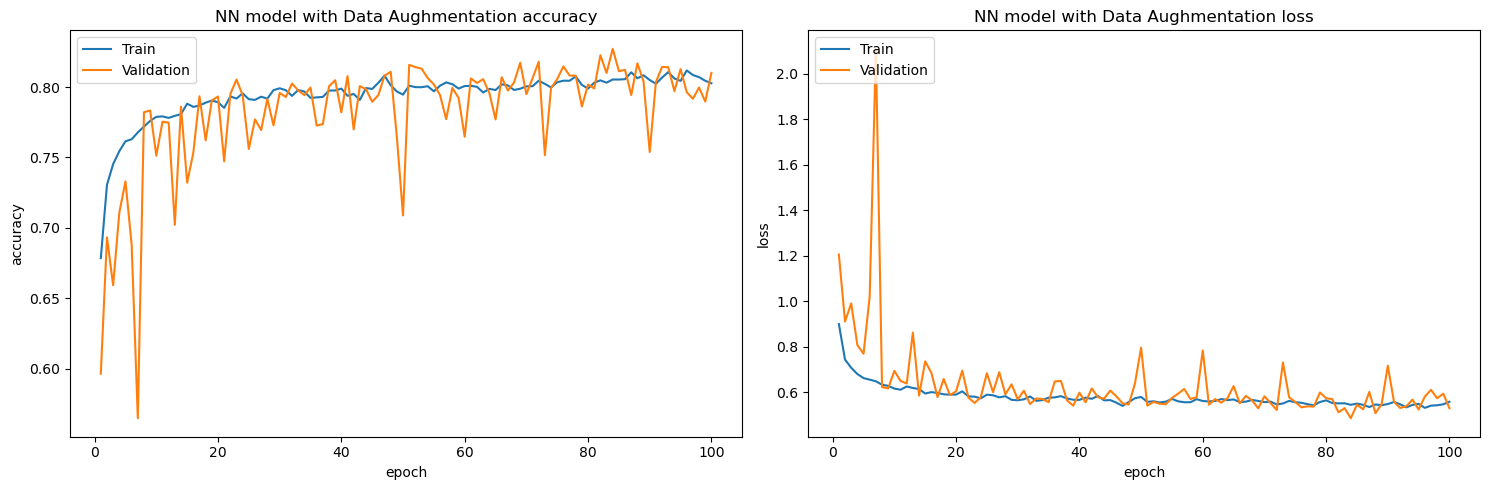

In [89]:
PlotTrainAndValidationAccuracyAndLoss(nn_model_with_data_aug_history, "NN model with Data Aughmentation")

313/313 - 1s - 2ms/step - accuracy: 0.8010 - loss: 0.5513

Test accuracy for NN model with data augmentation, dropout and batch normalization: 0.8010

Test loss for NN model with data augmentation, dropout and batch normalization: 0.5513

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
first 10 predicted outputs: [9 2 1 1 6 1 6 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for NN model with data augmentation, dropout and batch normalization :
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.96      0.96      0.96      1000
           2       0.72      0.62      0.66      1000
           3       0.88      0.76      0.81      1000
           4       0.73      0.55      0.63      1000
           5       0.91      0.93      0.92      1000
           6       0.45      0.67      0.54      1000
           7       0.91      0.88      0.90      1000
           8       0.93      0.90      0.91

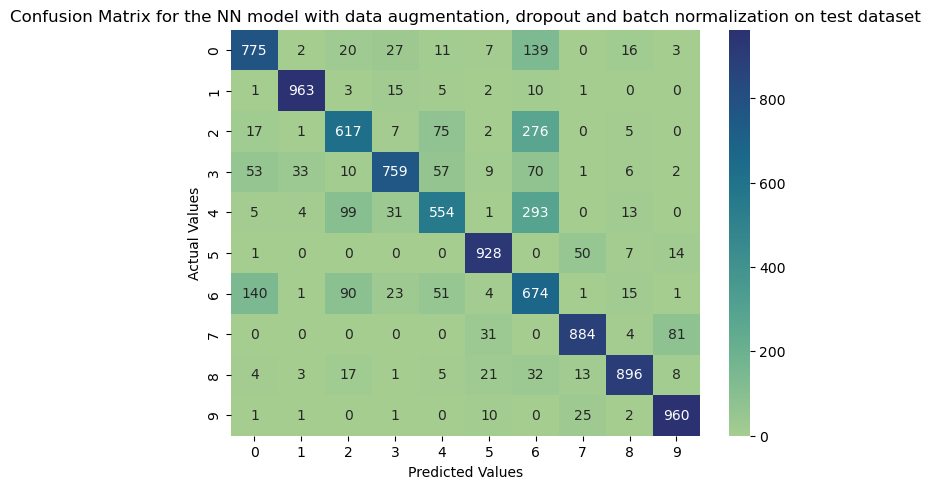

In [90]:
nn_model_softmax = EvaluateNeuralNetworkModel(nn_model_with_data_aug, test_images, test_labels, test_labels_onehot, "NN model with data augmentation, dropout and batch normalization")

## Please use the Fashion MNIST dataset in Q1 to implement the following network along with batch normalization and dropout layers.

### ANN Model with Concatenation (input layer and dense layer)

**Model Architecture**
- Input layer accepts gray scale image of size 28 * 28 pixels. 
- Received input is flattened and passed to 1st dense layer. 
- First dense layer contains 256 neurons with ReLU as activation function and output is passed to second dense layer as input. 
- second dense layer contains 784 neurons and ReLU activation function. 
- Second dense layer's output is then reshaped into 28 * 28 * 1 shape to match to the shape of input. 
- Input is then concatenated with the sencond dense layer's output. 
- After concatenation, output is then flattened and passed into the fully connected layer. 
- Fully connected layer contains 256 neurons and ReLU activation function. 
- Finally, Fully connected layer is connected with output layer and output layer contains 10 neurons and "Softmax" as activation function. 
- For optimization, We are using Adam Optimizer with initial learning rate of 0.005. 
- For loss calculation, we use Categorical Cross Entropy. 

In [91]:
# ann_model = tf.keras.Sequential()
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer1 = tf.keras.layers.Dense(units= 256, activation=  "relu")(flatten_layer)
dense_layer2 = tf.keras.layers.Dense(units= 784, activation=  "relu")(dense_layer1)
dense_layer2_reshaped = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(dense_layer2)
concatenated_layer = tf.keras.layers.Concatenate(axis=-1)([input_layer, dense_layer2_reshaped])
flatten_layefromr2 = tf.keras.layers.Flatten()(concatenated_layer)
fully_connected_layer = tf.keras.layers.Dense(units= 256, activation= "relu")(flatten_layer)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(fully_connected_layer)

ann_model = tf.keras.Model(
    input_layer,
    output_layer
)

ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

ann_model_history = ann_model.fit(train_images, train_labels_onehot , epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7731 - loss: 0.6394 - val_accuracy: 0.8518 - val_loss: 0.4162
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8547 - loss: 0.4000 - val_accuracy: 0.8653 - val_loss: 0.3794
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8684 - loss: 0.3635 - val_accuracy: 0.8640 - val_loss: 0.3936
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8771 - loss: 0.3358 - val_accuracy: 0.8631 - val_loss: 0.4061
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8828 - loss: 0.3208 - val_accuracy: 0.8710 - val_loss: 0.3853
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8871 - loss: 0.3085 - val_accuracy: 0.8750 - val_loss: 0.3583
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8926 - loss: 0.2921 - val_accuracy: 0.8699 - val_loss: 0.3815
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8949 - loss: 0.2825 - val_accu

In [92]:
ann_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,592 (2.33 MB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,062 (1.55 MB)

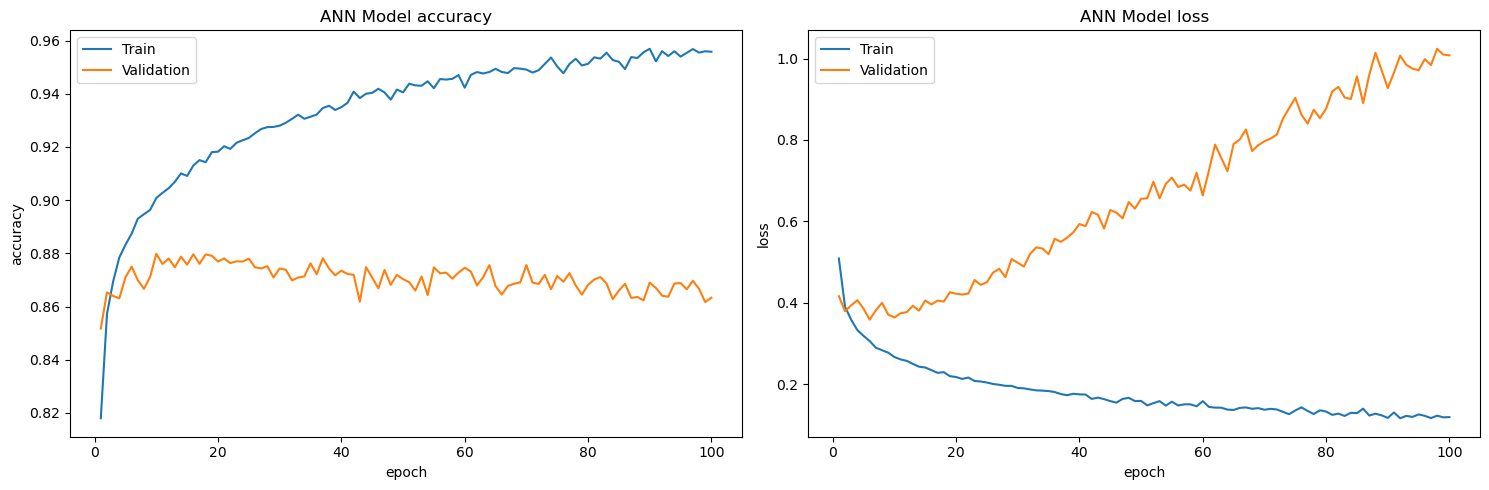

In [93]:
PlotTrainAndValidationAccuracyAndLoss(ann_model_history, "ANN Model")

313/313 - 0s - 1ms/step - accuracy: 0.8566 - loss: 1.0744

Test accuracy for ANN Model with concatenation: 0.8566

Test loss for ANN Model with concatenation: 1.0744

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
first 10 predicted outputs: [9 6 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for ANN Model with concatenation :
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1000
           1       0.98      0.97      0.98      1000
           2       0.78      0.72      0.75      1000
           3       0.86      0.85      0.86      1000
           4       0.78      0.74      0.76      1000
           5       0.98      0.94      0.96      1000
           6       0.56      0.76      0.65      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.96      0.96      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0

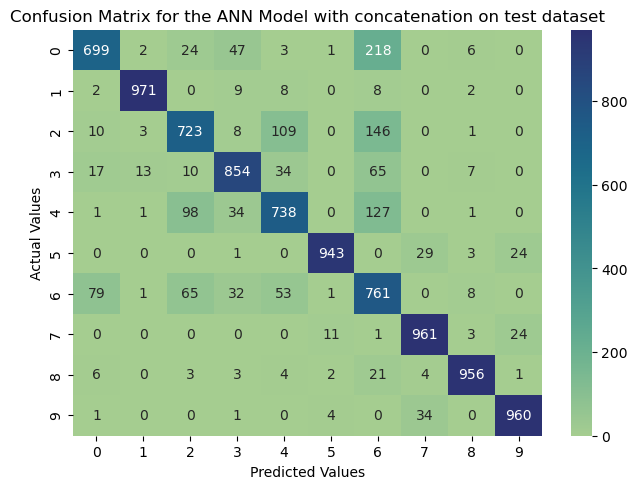

array([[0.0000000e+00, 1.1210388e-44, 0.0000000e+00, ..., 4.4149771e-11,
        0.0000000e+00, 1.0000000e+00],
       [6.5524479e-13, 3.8406438e-28, 1.6301040e-01, ..., 0.0000000e+00,
        6.3300883e-31, 7.5670117e-44],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.4841551e-44, 0.0000000e+00, 3.3911423e-43, ..., 8.8134475e-27,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2099752e-18, 2.5067601e-30, 1.0793141e-20, ..., 1.1668591e-08,
        4.9648553e-12, 3.3644979e-17]], dtype=float32)

In [94]:
EvaluateNeuralNetworkModel(ann_model, test_images, test_labels, test_labels_onehot, "ANN Model with concatenation")

### ANN model with concatenation, dropout and batch normalization

**Model Architecture**
- Input layer accepts gray scale image of size 28 * 28 pixels. 
- Received input is flattened and passed to 1st dense layer. 
- First dense layer contains 256 neurons with ReLU as activation function and output is passed to batch normalization.
- Normalized outputs are then passed into second dense layer as input. 
- second dense layer contains 784 neurons and ReLU activation function. 
- Second dense layer's output is then again passed through second batch normalization. 
- Output from second batch normalization is then reshaped into 28 * 28 * 1 shape to match to the shape of input. 
- Input is then concatenated with the sencond dense layer's output. 
- After concatenation, model is then passed to the dropout layer to randomly reset the weights in fraction of neurons.
- After dropout, output is then flattened and passed into the fully connected layer. 
- Fully connected layer contains 256 neurons and ReLU activation function. 
- Finally, Fully connected layer is connected with output layer and output layer contains 10 neurons and "Softmax" as activation function. 
- For optimization, We are using Adam Optimizer with initial learning rate of 0.005. 
- For loss calculation, we use Categorical Cross Entropy. 

In [95]:
# ann_model = tf.keras.Sequential()
input_layer_model2 = tf.keras.layers.Input(shape = (28, 28,1))
flatten_layer_model2 = tf.keras.layers.Flatten()(input_layer_model2)
dense_layer1_model2 = tf.keras.layers.Dense(units= 256, activation=  "relu")(flatten_layer_model2)
batch_normalization1_model2 = tf.keras.layers.BatchNormalization()(dense_layer1_model2)
dense_layer2_model2 = tf.keras.layers.Dense(units= 784, activation=  "relu")(batch_normalization1_model2)
batch_normalization2_model2 = tf.keras.layers.BatchNormalization()(dense_layer2_model2)
dense_layer2_reshaped_model2 = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(batch_normalization2_model2)
concatenated_layer_model2 = tf.keras.layers.Concatenate(axis=-1)([input_layer_model2, dense_layer2_reshaped_model2])
dropout_layer_model2 = tf.keras.layers.Dropout(0.05)(concatenated_layer_model2)
flatten_layer2_model2 = tf.keras.layers.Flatten()(dropout_layer_model2)
fully_connected_layer_model2 = tf.keras.layers.Dense(units= 256, activation= "relu")(flatten_layer2_model2)
output_layer_model2 = tf.keras.layers.Dense(10, activation='softmax')(fully_connected_layer_model2)

ann_model2 = tf.keras.Model(
    input_layer_model2,
    output_layer_model2
)

ann_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

ann_model2_history = ann_model2.fit(train_images, train_labels_onehot , epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7752 - loss: 0.6750 - val_accuracy: 0.8159 - val_loss: 0.5441
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8516 - loss: 0.4132 - val_accuracy: 0.8579 - val_loss: 0.4071
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8627 - loss: 0.3740 - val_accuracy: 0.8515 - val_loss: 0.4208
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8723 - loss: 0.3480 - val_accuracy: 0.8538 - val_loss: 0.4195
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8796 - loss: 0.3285 - val_accuracy: 0.8323 - val_loss: 0.4692
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8843 - loss: 0.3152 - val_accuracy: 0.8295 - val_loss: 0.5143
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8894 - loss: 0.3000 - val_accuracy: 0.8575 - val_loss: 0.4241
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8925 - loss: 0.2906 - val_accu

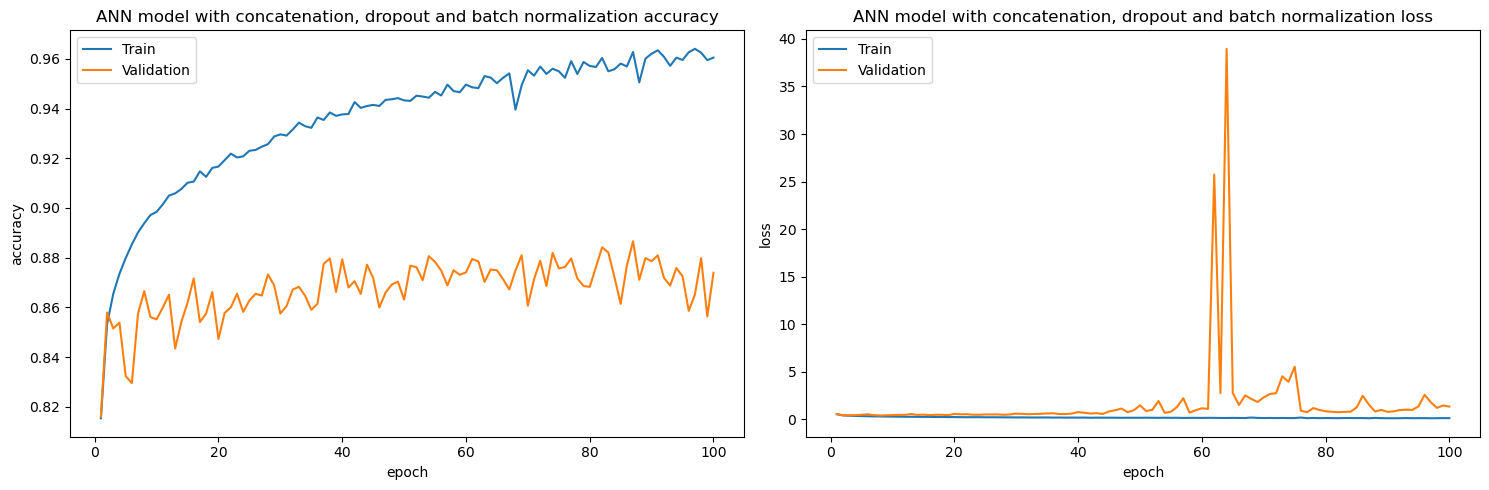

In [96]:
PlotTrainAndValidationAccuracyAndLoss(ann_model2_history, "ANN model with concatenation, dropout and batch normalization")

313/313 - 0s - 1ms/step - accuracy: 0.8682 - loss: 1.4397

Test accuracy for ANN model with concatenation, dropout and batch normalization: 0.8682

Test loss for ANN model with concatenation, dropout and batch normalization: 1.4397

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for ANN model with concatenation, dropout and batch normalization :
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1000
           1       0.98      0.97      0.98      1000
           2       0.74      0.83      0.78      1000
           3       0.92      0.85      0.88      1000
           4       0.81      0.74      0.77      1000
           5       0.96      0.95      0.95      1000
           6       0.62      0.77      0.69      1000
           7       0.92      0.95      0.94      1000
           8       0.97      0.95      0.96      100

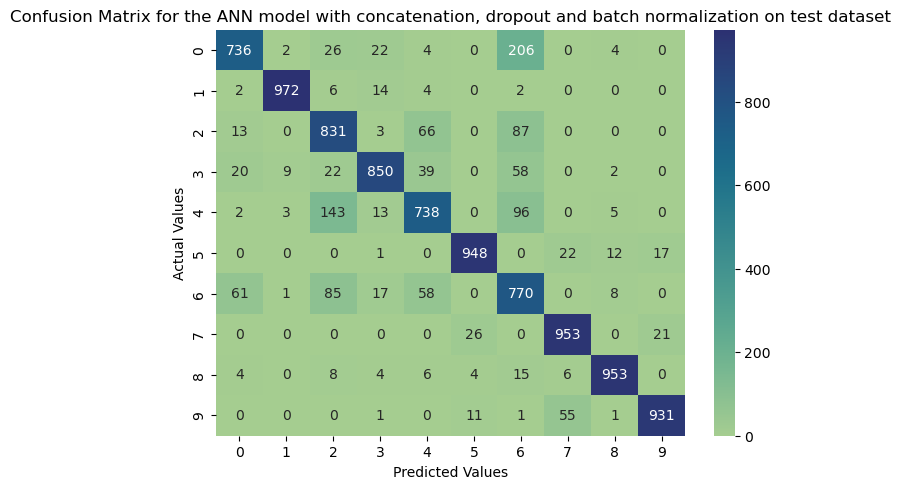

array([[0.0000000e+00, 3.8738111e-39, 0.0000000e+00, ..., 1.0756114e-04,
        1.1064896e-36, 9.9989235e-01],
       [1.7054098e-17, 2.7082511e-32, 9.9999678e-01, ..., 0.0000000e+00,
        2.8152655e-17, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.4158647e-27, 0.0000000e+00, 0.0000000e+00, ..., 9.0146795e-19,
        0.0000000e+00, 4.3163415e-26]], dtype=float32)

In [97]:
EvaluateNeuralNetworkModel(ann_model2, test_images, test_labels, test_labels_onehot, "ANN model with concatenation, dropout and batch normalization")